# Introduction

MNIST 데이터베이스(Modified National Institute of Standards and Technology database)는 미국의 학생들이 직접 쓴 손글씨를 머신러닝에 사용될 수 있도록 만들어진 것입니다. 이를 활용해 주어진 이미지 파일에서 숫자를 판별할 수 있는 판별기(classifier)를 만들고 실무에 적용하는 사례가 많습니다. 하지만, 문화권에 따라 손글씨의 형태가 다른 점을 감안한다면 우리나라에서 MNIST 데이터베이스를 그대로 사용하기에는 다소 무리가 있다고 생각합니다. 아래의 사진(미국인의 손글씨)에서처럼 1, 7 등 전반적인 숫자의 형태가 우리나라와 다른 것을 알 수 있습니다.

![미국인의 숫자 글씨체](number.png)

머신러닝 모델 중 전반적으로 뛰어난 성능을 보여주고 있는 `Random Forest` 모델을 사용하여 MNIST 데이터베이스가 우리나라 글씨에 얼마나 적합(suitable)한지 알아보려고 합니다. 이를 위해, MNIST 데이터베이스를 적합(fit)한 모델로 직접 쓴 숫자글씨를 얼마나 잘 예측하는지 확인하는 것을 목표로 설정하였습니다. 이 후에 사용되는 모든 이미지 파일은 직접 작성하였습니다.

# Main

## 이미지 데이터 전처리

이미지 데이터를 분석가능한 형태로 가공하기 위해 `OpenCV` 라이브러리를 이용합니다. `OpenCV`(Open Source Computer Vision)는 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리입니다.

### 이미지 불러오기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

'test.jpeg' 이미지 파일을 불러와서 확인하는 모습입니다. 10개의 숫자가 나열되어 있고 이들을 판별하고자 합니다. 하지만, 10개의 숫자가 있다는 것은 우리의 눈으로 확인한 것이지 컴퓨터는 알아차릴 수 없습니다. 따라서 판별하기 전에 이미지 파일로부터 숫자를 검출하는 과정이 필요합니다.

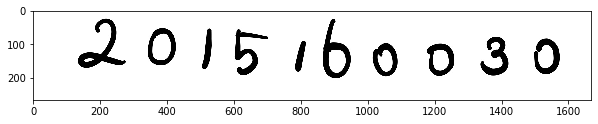

In [2]:
img=cv2.imread('test.jpeg')
plt.figure(figsize=(10,6))
plt.imshow(img);

### 색 변환과 Blur 처리

이미지 파일에서 자동적으로 숫자를 검출하기 위해 RGB요소를 Gray Scale로 바꿔주어야 합니다. cv2 라이브러리의 `cvtColor`가 그 역할을 담당합니다. `cv2.COLOR_BGR2GRAY` 옵션이 Gray Scale로 바꾸어주는 옵션입니다. 변환 결과는 다음과 같습니다.

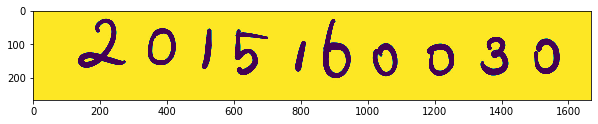

In [3]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,6))
plt.imshow(img_gray);

Gray Scale로 변환한 뒤 이미지의 잡음(noise) 제거와 경계검출을 위해 Blurring 작업이 필요합니다. 이는 Image Smoothing 과정이기도 합니다. 경계가 조금 더 매끄럽게 처리된 것을 확인할 수 있습니다. 이미지에 잡음이 없고 구분이 명확하여 Blur 처리하여도 큰 차이가 없지만, 실제로는 처리가 필요한 이미지가 대다수입니다.

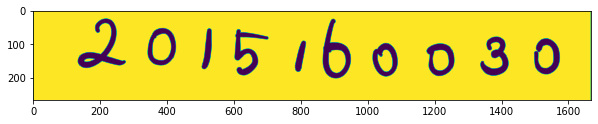

In [4]:
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
plt.figure(figsize=(10,6))
plt.imshow(img_blur);

### 이미지 속 숫자 검출

앞선 과정을 거쳤다면 이제 이미지로부터 숫자를 검출할 수 있습니다. 먼저 `cv2.threshold` 함수를 사용하여 색이 있는 부분과 없는 곳을 구분 짓습니다. 이것의 원리는 하나의 픽셀이 임계값인 120을 넘지 못하면 0, 넘으면 255을 부여하는 방식입니다. 이 정보는 `img_th`에 저장해줍니다.

In [5]:
ret, img_th = cv2.threshold(img_blur, 120, 255, cv2.THRESH_BINARY_INV)

다음으로 `cv2.findContours` 함수를 사용하여 경계를 구성하는 픽셀을 찾습니다. 그리고 `cv2.boundingRect` 함수로 앞서 찾은 픽셀을 이용해 숫자를 감싸는 사각형을 찾습니다. `rects` 값이 사각형을 이루는 꼭짓점의 좌표를 가지고 있는 상태입니다.

In [6]:
contours, hierachy= cv2.findContours(img_th.copy(), 
                                 cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rects = [cv2.boundingRect(each) for each in contours]

`rects`를 한 번 더 살펴보겠습니다. 각 요소들은 `(x,y,w,h)`의 순서로 구성되어 있는데 `(x,y)`는 사각형의 왼쪽 위 좌표, `(w,h)`는 각각 폭과 높이를 나타냅니다. 또한 `rects`의 원소 갯수를 통해 몇 개의 숫자를 검출했는지 확인할 수 있습니다. 10개의 숫자가 잘 검출되었습니다.

In [7]:
print('검출된 숫자의 갯수 : %d' % len(rects))
print(rects[0], '는 (1177, 98)를 왼쪽 위 꼭짓점으로 하고 폭이 82 높이가 96인 사각형을 의미')

검출된 숫자의 갯수 : 10
(1177, 98, 82, 96) 는 (1177, 98)를 왼쪽 위 꼭짓점으로 하고 폭이 82 높이가 96인 사각형을 의미


### 검출된 숫자 확인

마지막으로 10개의 숫자가 잘 검출되었는지 확인해야 합니다. `rects`의 값과 `cv2.rectangle`함수를 이용하면 이미지 파일에 사각형을 추가할 수 있습니다.

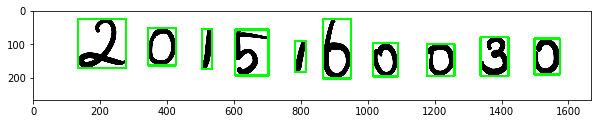

In [8]:
img_copy = img.copy()

for rect in rects:
    #[x,y]를 왼쪽 위, [x+w, y+h]를 오른쪽 아래 꼭짓점으로 가지는 사각형을 그린다.
    #(0,255,0)은 색깔을 지정해주며 5는 선 두께이다.
    cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 5)

plt.figure(figsize=(10,6))
plt.imshow(img);

숫자들이 잘 검출되었으므로 이미지 파일에서 숫자에 해당하는 부분만 뽑아냅니다. 약간의 여백(`margin_pixel`)을 주고 저장합니다.

In [9]:
#숫자로 검출된 부분을 저장하기 위한 list
img_result = []

margin_pixel = 20

#여백을 주고 숫자만 담기
for rect in rects:
    img_result.append(
        img_copy[rect[1]-margin_pixel : rect[1]+rect[3]+margin_pixel,
                 rect[0]-margin_pixel : rect[0]+rect[2]+margin_pixel])

검출된 숫자가 담겨있는 `img_result`의 원소들을 그려보면 다음과 같습니다. 하지만, MNIST 데이터베이스는 28*28 크기이기 때문에 모델에 적합하기 위해 크기를 바꿔주어야 합니다.

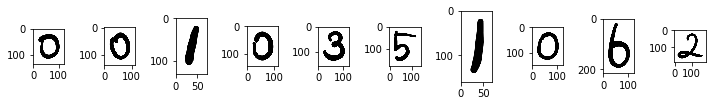

In [10]:
count = 0; nrows = 1; ncols = 10

plt.figure(figsize=(10,6))

for n in img_result:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(n, cmap='Greys', interpolation='nearest')

plt.tight_layout()
plt.show();

28*28의 크기로 바꾼 모습입니다.

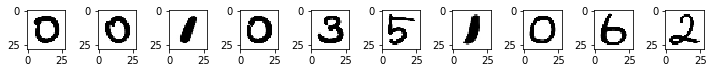

In [11]:
count = 0; nrows = 1; ncols = 10

plt.figure(figsize=(10,6))

for n in img_result:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(cv2.resize(n,(28,28)), cmap='Greys', interpolation='nearest')

plt.tight_layout()
plt.show();

앞선 과정을 하나의 함수(`img2data`)로 정의합니다. 함수의 반환값은 검출된 숫자들을 28*28 크기로 변경한 후 길이가 784(=28^2)인 1D array로 변환하여 저장한 `data2use`와 `rects`입니다.

In [12]:
def img2data(filename, margin):
    #이미지 불러오기, 색 변화과 Blur 처리
    img = cv2.imread(filename)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #Thresholding & findContour
    ret, img_th = cv2.threshold(img_blur, 120, 230, cv2.THRESH_BINARY_INV)
    contours, hierachy = cv2.findContours(img_th.copy(), 
                                          cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(each) for each in contours]
    
    #숫자 검출 및 저장
    img_result = []
    img_copy = img.copy()

    margin_pixel = margin

    for rect in rects:
        img_result.append(
            img_copy[rect[1] - margin_pixel : rect[1] + rect[3] + margin_pixel,
                     rect[0] - margin_pixel : rect[0] + rect[2] + margin_pixel] )
        
    data2use = []
    for result in img_result:
        data = cv2.resize(result, (28, 28))[:,:,1] #28*28 크기로 변경
        data = 255 - data #색상 반전
        data = data.reshape(784) #1D array로 변환
        data2use.append(data)
    data2use=np.array(data2use)
    
    return data2use, rects

'test.jpeg' 파일을 함수에 넣어주면 784길이의 array 10개가 반환됩니다. 이미지 파일의 숫자가 10개이기 때문입니다.

In [13]:
data2use, rects=img2data('test.jpeg', 20)
data2use.shape

(10, 784)

## 숫자 판별

sklearn에서 제공하는 `RandomForestClassifier`에 `MNIST Data`를 적합시킨 후, 성능을 확인해보겠습니다. 먼저 다음의 함수(`num_clf`)를 정의합니다. 이 함수는 모델이 예측한 결과를 이미지 파일에 나타내주는 함수입니다. 실행결과는 뒤에서 확인해보도록 하겠습니다.

In [14]:
def num_clf(filename, clf, margin, plt_width ,plt_height):
    data2use, rects = img2data(filename, margin)
    img = cv2.imread(filename)
    
    i = 0
    for rect in rects:
        cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 5)
    
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(clf.predict(data2use)[i]), (rect[0] - 25,rect[1] + 25), font, 2, (0,0,255), 5)
        i += 1
    
    plt.figure(figsize = (plt_width, plt_height))
    plt.imshow(img);

### 모델 적합 및 성능 평가

MNIST 데이터베이스를 불러옵니다. MNIST 데이터베이스는 숫자 이미지 파일을 데이터화한 것으로 길이가 784인 1D array가 70000개 포함되어있습니다. 앞선 전처리 과정에서 크기를 변경해준 이유입니다.

In [15]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

`RandomForestClassifier`를 적합하고 숫자를 예측해 보았습니다. 다음 그림은 앞서 정의한 `num_clf` 함수를 사용한 결과입니다. 10개의 숫자 중 8개의 숫자를 잘 판별하였습니다. 1은 8로, 6은 5로 잘못 판별하였습니다.

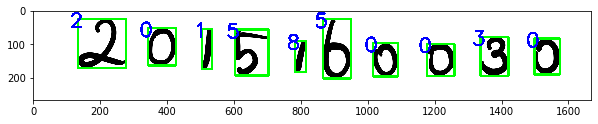

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100 ,random_state=1)
rf.fit(mnist.data, mnist.target)
num_clf('test.jpeg', rf, 20, 10, 6)

### 추가 이미지 예측

위의 이미지 파일 외에 추가 이미지 파일을 예측해보았습니다. 5와 6은 절반정도를 잘 예측했지만, 8과 9는 전혀 예측하지 못하였습니다.

In [17]:
files=[str(i)+'.png' for i in range(0,10)]

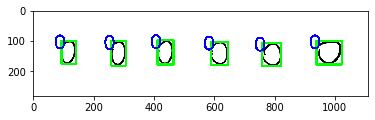

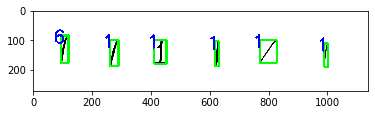

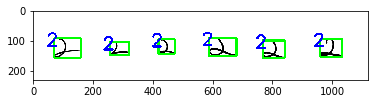

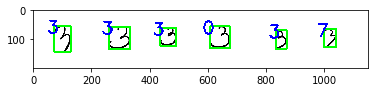

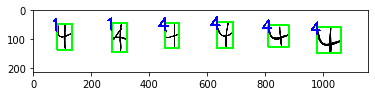

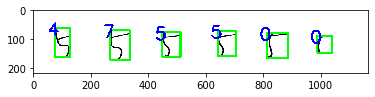

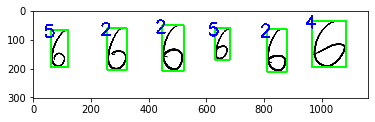

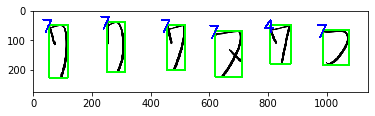

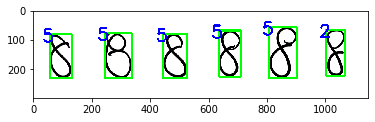

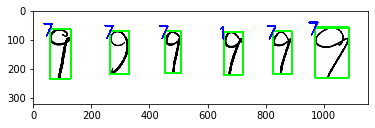

In [18]:
for file in files:
    num_clf(file, rf, 20, 6, 4)

# Conclusion

## Results

앞선 10개의 숫자를 이용한 예측은 정확도가 80%였으나, 추가 이미지 데이터에 대한 정확도는 약 62%(예측성공:37, 예측실패:23)였습니다. 특히, 6, 8, 9와 같이 혼동하기 쉬운 숫자의 경우 정확도가 상당히 떨어졌습니다. 따라서 MNIST 데이터베이스만으로 우리나라의 손글씨를 판별하는기에는 다소 무리가 있다고 판단됩니다. 이에 따라 데이터를 새로 수집하여 우리나라에 적합한 데이터베이스를 만들 필요가 있다고 생각합니다.

![confusion matrix](confusion_matrix.png)

정확도가 높지 않은 것에 대해서는 또 다른 이유가 있습니다. 실무에서는 MNIST 데이터베이스처럼 정사각형 틀 안에 숫자만 고스란히 담겨져 있는 데이터를 제공받지 않습니다. 따라서 이미지 파일에서 숫자를 검출하는 과정이 꼭 자동화되어야 합니다. 하지만 이미지 내의 숫자가 1)너무 얇거나 굵을때 2)중앙으로부터 치우쳐있거나 찌그러져 있을때 3)너무 작을때 자동화 과정에서 숫자를 검출하는 사각형(`rects`)이 제대로 생성되지 않습니다. 그 결과 예측이 틀릴 확률이 높아지는 것입니다. 추가 이미지 파일에서도 이러한 이유로 잘 예측하지 못한 것을 알 수 있습니다.

많은 사람들로부터 손글씨를 제공받아 전처리한 후 MNIST 데이터베이스에 추가하여 모델을 적합해보지 못한 것에 아쉬움이 남습니다. 직접 작성한 500개 남짓의 손글씨를 추가하여 적합하고 예측해보았으나 70000개의 데이터에 비해 너무 적었던 탓에 성능이 개선되지 않았습니다. 또, MNIST 데이터베이스를 사용하지 않고 직접 작성한 데이터만을 이용해보기도 했지만 이 경우에도 표본의 수가 너무 적었기에 좋은 성능을 보여주지 못했습니다.

## Discussion

머신러닝 분석에서 모델 적합(Model fitting) 그리고 예측(Prediction) 과정은 전체 과정의 10~20% 밖에 차지하지 않는 것을 알 수 있었습니다. 또한, 이미지 파일을 전처리하면서 데이터를 수집하고 분석에 필요한 형태로 가공하는 과정이 가장 어려운 부분이라는 것 또한 경험하였습니다. 잘못 전처리된 데이터를 이용하여 모델을 적합하면 잘못된 모델이 도출되고 결국 정확도는 낮아질 수 밖에 없습니다. 따라서 모델에 대한 이해도 중요하지만, 주어진 데이터를 잘 들여다보고 어떤 모델을 사용해야하며, 어떻게 처리(preprocessing)해야 할지 고민해보는 것이 선행되어야 한다고 생각합니다.

# Bibliography

1. Wikipedia(2019). *MNIST 데이터베이스*. Retrieved from https://ko.wikipedia.org/wiki/MNIST_데이터베이스

2. OpenCV(2014). *OpenCV API Reference*. Retrieved from https://docs.opencv.org/2.4/modules/refman.html

3. scikit-learn(2019). *scikit-learn.org*. Retrieved from https://scikit-learn.org